In [1]:
import litebird_sim as lbs
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import warnings

%matplotlib inline
plt.rcParams.update({"font.size": 16})
warnings.filterwarnings("ignore")

# Single-frequency case

In [2]:
# general
nside = 64
n_months = 3
sim_days = 30 * n_months
channel = "M1-100"
instrument = channel[0] + "FT"
sampling = 1  # this replaces channelinfo.sampling_rate_hz
imo_version = "vPTEP"  # "v1.3"

# simulation parameters
base_path = "./HWP_tutorial"
start_time = "2030-04-01T00:00:00"

# hwp_sys parameters
integrate_in_band = "false"  # watch out, use lower case letters for .toml file
integrate_in_band_solver = "false"  # watch out, use lower case letters for .toml file
built_map_on_the_fly = "true"  # watch out, use lower case letters for .toml file
correct_in_solver = "true"  # watch out, use lower case letters for .toml file

# for scanning, i.e. tod filling
h1 = -0.1  # has to be negative: non-unitary transmission
h2 = -0.2  # has to be negative: non-unitary transmission
z1 = 1e-3 + 1j * 1e-3  # cross-polarization
z2 = 9e-4 + 1j * 1e-3  # cross-polarization
beta = 13  # degrees, phase-shift

# for solver, i.e. map-making (for showing purposes we take them equal to previous ones)
h1s = -0.1
h2s = -0.2
z1s = 1e-3 + 1j * 1e-3
z2s = 9e-4 + 1j * 1e-3
betas = 13

In [3]:
# creation of a parameter (.toml) file
toml_filename = "./HWP_tutorial.toml"
with open(toml_filename, "w") as f:
    f.write("[general]\n")  # --------------- GENERAL ---------------
    f.write("imo_version       = '" + imo_version + "'\n")
    f.write("instrument        = '" + instrument + "'\n")
    f.write("channel           = '" + channel + "'\n")
    f.write("nside             = " + str(nside) + "\n")
    f.write("mission_time_days = '" + str(sim_days) + "'\n\n")

    f.write("[simulation]\n")  # --------------- SIMULATION ---------------
    f.write("base_path  = '" + base_path + "'\n")
    f.write("start_time = '" + start_time + "'\n")
    f.write("duration_s = '" + str(sim_days) + " days'\n")
    f.write("name       = '" + "HWP_tutorial'\n\n")

    f.write("[hwp_sys]\n")  # --------------- HWP_SYS ---------------
    f.write(f"integrate_in_band        = {integrate_in_band} \n")
    f.write(f"integrate_in_band_solver = {integrate_in_band_solver} \n")
    f.write(f"built_map_on_the_fly     = {built_map_on_the_fly} \n")
    f.write(f"correct_in_solver        = {correct_in_solver} \n")
    f.write(f"h1   = {h1}\n")
    f.write(f"h2   = {h2}\n")
    f.write(f"z1   = '{z1}'\n")  # here written as a string since it is complex
    f.write(f"z2   = '{z2}'\n")  # here written as a string since it is complex
    f.write(f"beta = {beta}\n")
    f.write(f"h1s   = {h1s}\n")
    f.write(f"h2s   = {h2s}\n")
    f.write(f"z1s   = '{z1s}'\n")  # here written as a string since it is complex
    f.write(f"z2s   = '{z2s}'\n")  # here written as a string since it is complex
    f.write(f"betas = {betas}\n")
    f.close()

In [4]:
# imo = lbs.Imo()
imo = lbs.Imo(flatfile_location=lbs.PTEP_IMO_LOCATION)
sim = lbs.Simulation(
    parameter_file=toml_filename,
    random_seed=0,
)

In [5]:
instrumentinfo = lbs.InstrumentInfo.from_imo(
    imo, f"/releases/{imo_version}/satellite/{instrument}/instrument_info"
)

sim.set_instrument(instrumentinfo)

sim.set_scanning_strategy(
    imo_url=f"/releases/{imo_version}/satellite/scanning_parameters/"
)

channelinfo = lbs.FreqChannelInfo.from_imo(
    url=f"/releases/{imo_version}/satellite/{instrument}/{channel}/channel_info",
    imo=imo,
)

hwp_radpsec = lbs.IdealHWP(
    instrumentinfo.hwp_rpm * 2 * np.pi / 60,
).ang_speed_radpsec

sim.set_hwp(lbs.IdealHWP(hwp_radpsec))

In [6]:
dets = []

for detname in (
    "001_003_030_00A_100_T",
    "001_003_030_00A_100_B",
):  # we choose the couple of detector at the MFT boresight
    det = lbs.DetectorInfo.from_imo(
        url=f"/releases/{imo_version}/satellite/{instrument}/{channel}/{detname}/detector_info",
        imo=imo,
    )
    det.sampling_rate_hz = sampling
    dets.append(det)

#### Single-frequency: create input map and fill tod

In [7]:
(obs,) = sim.create_observations(detectors=dets)
sim.prepare_pointings()

In [8]:
Mbsparams = lbs.MbsParameters(
    make_cmb=True,
    seed_cmb=1234,
    cmb_r=0.0,
    make_fg=False,
    gaussian_smooth=True,
    bandpass_int=False,
    maps_in_ecliptic=False,
    nside=nside,
    units="K_CMB",
)

mbs = lbs.Mbs(
    simulation=sim,
    parameters=Mbsparams,
    channel_list=channelinfo,
)
input_map = mbs.run_all()[0][channel]

[2024-06-06 09:42:21,543 INFO MPI#0000] generating and saving cmb simulations
[2024-06-06 09:42:21,554 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2024-06-06 09:42:21,554 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2024-06-06 09:42:21,564 INFO MPI#0000] Access data from /Users/nraff/Desktop/phd/litebird/litebird_sim/litebird_sim/hwp_sys/examples/HWP_tutorial/cmb/0000/cmb_0000_date_240606.fits
[2024-06-06 09:42:21,565 INFO MPI#0000] NSIDE = 64
[2024-06-06 09:42:21,565 INFO MPI#0000] ORDERING = RING in fits file
[2024-06-06 09:42:21,565 INFO MPI#0000] INDXSCHM = IMPLICIT
[2024-06-06 09:42:21,583 INFO MPI#0000] Sigma is 16.052182 arcmin (0.004669 rad) 
[2024-06-06 09:42:21,583 INFO MPI#0000] -> fwhm is 37.800000 arcmin
[2024-06-06 09:42:21,584 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2024-06-06 09:42:21,584 INFO MPI#0000] -> fwhm is 0.000000 arcmin


***************** D
***************** D
***************** D


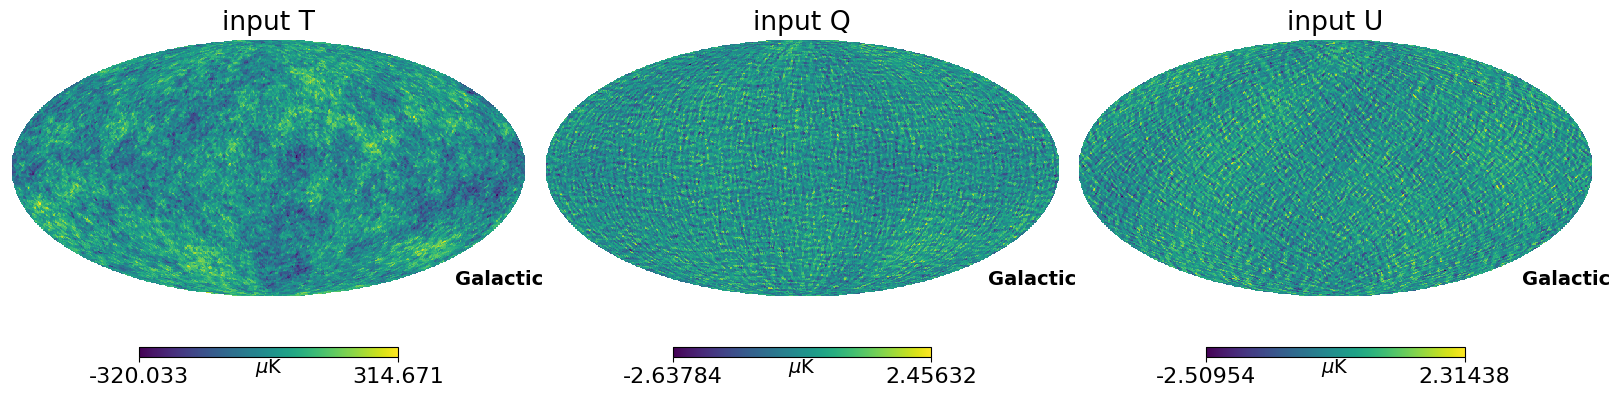

In [9]:
plt.figure(figsize=(16, 10))
hp.mollview(
    input_map[0] * 1e6, unit="$\mu$K", sub=(1, 3, 1), title="input T", coord=["G"]
)
hp.mollview(
    input_map[1] * 1e6, unit="$\mu$K", sub=(1, 3, 2), title="input Q", coord=["G"]
)
hp.mollview(
    input_map[2] * 1e6, unit="$\mu$K", sub=(1, 3, 3), title="input U", coord=["G"]
)
plt.tight_layout()

In [10]:
hwp_sys = lbs.HwpSys(sim)

hwp_sys.set_parameters(
    nside=nside,
    mueller_or_jones="jones",
    maps=input_map,
    Channel=channelinfo,
    #     integrate_in_band=integrate_in_band,
    #     integrate_in_band_solver=integrate_in_band_solver,
    #     correct_in_solver=correct_in_solver,
    #     built_map_on_the_fly=built_map_on_the_fly,
)
# previous 4 lines are non necessary since variables are passed with the toml file
print(
    hwp_sys.integrate_in_band,
    hwp_sys.integrate_in_band_solver,
    hwp_sys.correct_in_solver,
    hwp_sys.built_map_on_the_fly,
)

print("This is a Mueller matrix for a non-ideal HWP.\n\nDiagonal terms (tod filling):")
print(f"mII = {hwp_sys.mII:.1f}, mQQ = {hwp_sys.mQQ:.1f}, mUU = {hwp_sys.mUU:.1f}")
print("Off-diagonal terms (tod filling):")
print(
    f"mIQ = {hwp_sys.mIQ:.1f}, mIU = {hwp_sys.mIU:.1f}, mQU = {hwp_sys.mQU:.1f}, mQI = {hwp_sys.mQI:.1f}, mUI = {hwp_sys.mUI:.1f}, mUQ = {hwp_sys.mUQ:.1f}"
)

print("\n\nDiagonal terms (map-making):")
print(
    f"mIIs = {hwp_sys.mIIs:.1f}, mQQs = {hwp_sys.mQQs:.1f}, mUUs = {hwp_sys.mUUs:.1f}"
)
print("Off-diagonal terms (map-making):")
print(
    f"mIQs = {hwp_sys.mIQs:.1f}, mIUs = {hwp_sys.mIUs:.1f}, mQUs = {hwp_sys.mQUs:.1f}, mQIs = {hwp_sys.mQIs:.1f}, mUIs = {hwp_sys.mUIs:.1f}, mUQs = {hwp_sys.mUQs:.1f}"
)

False False True True
This is a Mueller matrix for a non-ideal HWP.

Diagonal terms (tod filling):
mII = 0.7, mQQ = 0.7, mUU = -0.7
Off-diagonal terms (tod filling):
mIQ = 0.1, mIU = 0.0, mQU = 0.0, mQI = 0.1, mUI = -0.0, mUQ = 0.0


Diagonal terms (map-making):
mIIs = 0.7, mQQs = 0.7, mUUs = -0.7
Off-diagonal terms (map-making):
mIQs = 0.1, mIUs = 0.0, mQUs = 0.0, mQIs = 0.1, mUIs = 0.0, mUQs = 0.0


In [11]:
# we do not pass pointings, they are computed on the fly
# (i.e. for all time-samples but for 1 detector at a time)
# this reduces memory allocation without really slowing down the code
hwp_sys.fill_tod(
    observations=obs,
    input_map_in_galactic=True,
    # pointings=pointings,
    # hwp_angle=hwp_angle,
)

#### Single-frequency: building a map using litebird_sim binner

In [52]:
# we do not pass pointings, they are computed on the fly
# conversely we show below a way to pass them
# pointings = np.zeros((obs.n_detectors, obs.n_samples, 3))

# for cur_obs in sim.observations:
#     for det_idx in range(cur_obs.n_detectors):
#         point, hwp_angle = cur_obs.get_pointings(det_idx)
#         pointings[det_idx, :, :] = point

m_lbs = lbs.make_binned_map(
    nside,
    [obs],
)  # [pointings]

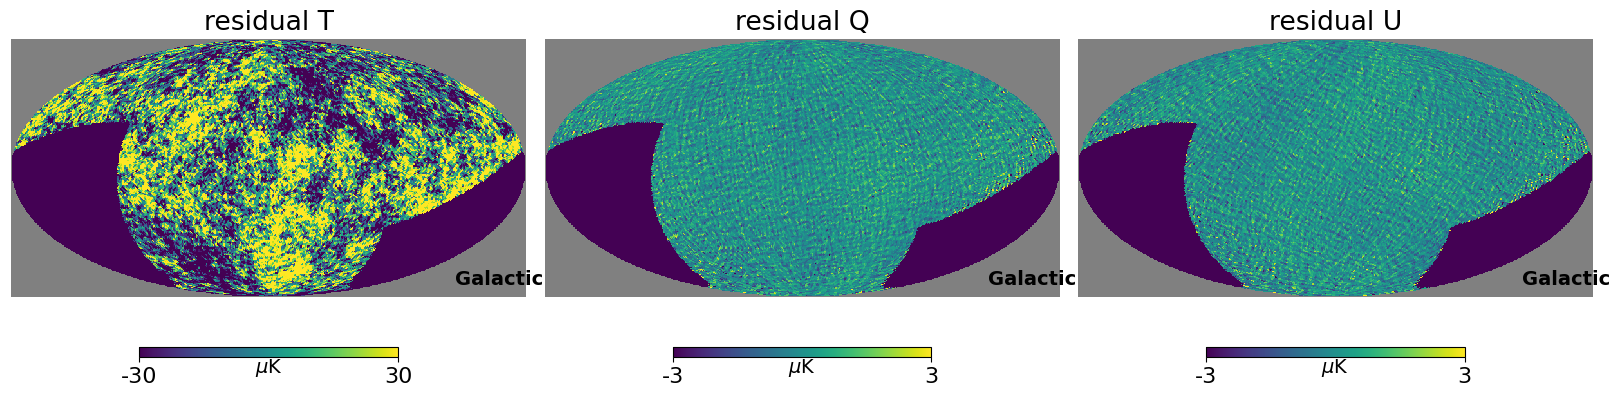

In [51]:
plt.figure(figsize=(16, 10))
ranges = 30
hp.mollview(
    (m_lbs.binned_map[0] - input_map[0]) * 1e6,
    unit="$\mu$K",
    sub=(1, 3, 1),
    title="residual T",
    coord=["G"],
    min=-ranges,
    max=ranges,
)
hp.mollview(
    (m_lbs.binned_map[1] - input_map[1]) * 1e6,
    unit="$\mu$K",
    sub=(1, 3, 2),
    title="residual Q",
    coord=["G"],
    min=-ranges * 1e-1,
    max=ranges * 1e-1,
)
hp.mollview(
    (m_lbs.binned_map[2] - input_map[2]) * 1e6,
    unit="$\mu$K",
    sub=(1, 3, 3),
    title="residual U",
    coord=["G"],
    min=-ranges * 1e-1,
    max=ranges * 1e-1,
)
plt.tight_layout()

#### Single-frequency: building a map "on the fly", i.e. HwpSys map-maker

In [14]:
m_onthefly = hwp_sys.make_map([obs])

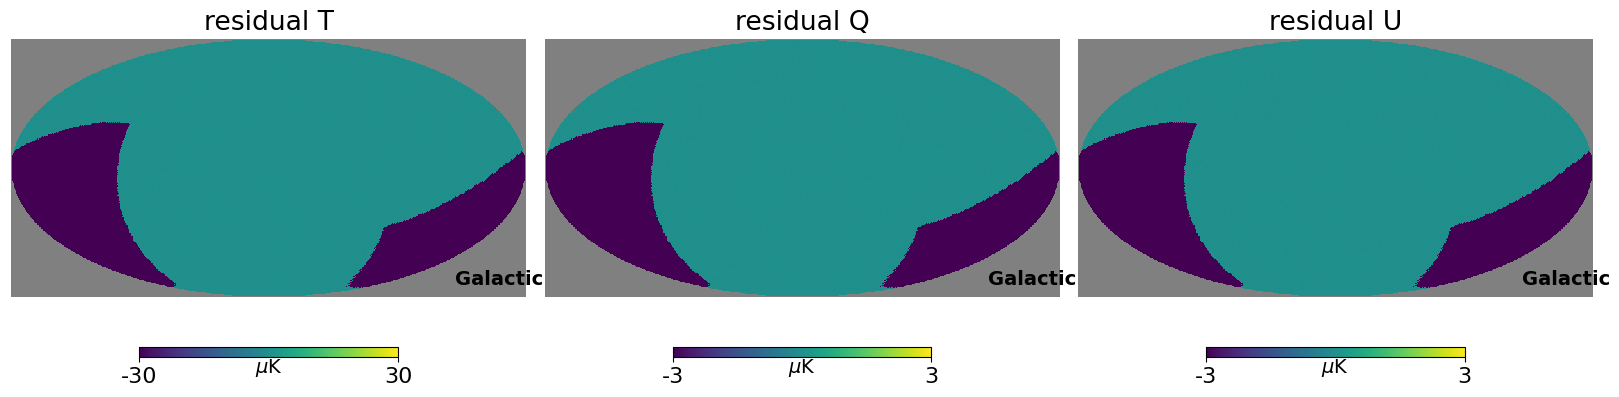

In [15]:
plt.figure(figsize=(16, 10))
ranges = 30
hp.mollview(
    (m_onthefly[0] - input_map[0]) * 1e6,
    unit="$\mu$K",
    sub=(1, 3, 1),
    title="residual T",
    coord=["G"],
    min=-ranges,
    max=ranges,
)
hp.mollview(
    (m_onthefly[1] - input_map[1]) * 1e6,
    unit="$\mu$K",
    sub=(1, 3, 2),
    title="residual Q",
    coord=["G"],
    min=-ranges * 1e-1,
    max=ranges * 1e-1,
)
hp.mollview(
    (m_onthefly[2] - input_map[2]) * 1e6,
    unit="$\mu$K",
    sub=(1, 3, 3),
    title="residual U",
    coord=["G"],
    min=-ranges * 1e-1,
    max=ranges * 1e-1,
)
plt.tight_layout()

## Multi-frequency case (band integration, default top-hat bandpass)

In [16]:
# general
nside = 64
n_months = 3
sim_days = 30 * n_months
channel = "M1-100"
instrument = channel[0] + "FT"
sampling = 1  # this replaces channelinfo.sampling_rate_hz
imo_version = "vPTEP"  # "v1.3"

# simulation parameters
base_path = "./HWP_tutorial"
start_time = "2030-04-01T00:00:00"

# hwp_sys parameters
integrate_in_band = "true"
integrate_in_band_solver = "true"
built_map_on_the_fly = "true"
correct_in_solver = "true"
del hwp_sys


# for band-integration, HWP systematics are passed through txt files
# order of the fields: frequency[GHz] h1 h2 beta[deg] z1 z2
# remember to set integrate_in_band and integrate_in_band_solver to 'true'
band_filename = "./HWP_systematics.txt"  # tod filling
band_filename_solver = "./HWP_systematics.txt"  # map-making

In [17]:
# creation of a parameter (.toml) file
toml_filename = "./HWP_tutorial.toml"
with open(toml_filename, "w") as f:
    f.write("[general]\n")  # --------------- GENERAL ---------------
    f.write("imo_version       = '" + imo_version + "'\n")
    f.write("instrument        = '" + instrument + "'\n")
    f.write("channel           = '" + channel + "'\n")
    f.write("nside             = " + str(nside) + "\n")
    f.write("mission_time_days = '" + str(sim_days) + "'\n\n")

    f.write("[simulation]\n")  # --------------- SIMULATION ---------------
    f.write("base_path  = '" + base_path + "'\n")
    f.write("start_time = '" + start_time + "'\n")
    f.write("duration_s = '" + str(sim_days) + " days'\n")
    f.write("name       = '" + "HWP_tutorial'\n\n")

    f.write("[hwp_sys]\n")  # --------------- HWP_SYS ---------------
    f.write(f"integrate_in_band        = {integrate_in_band}\n")
    f.write(f"integrate_in_band_solver = {integrate_in_band_solver}\n")
    f.write(f"built_map_on_the_fly     = {built_map_on_the_fly}\n")
    f.write(f"correct_in_solver        = {correct_in_solver}\n")
    f.write(
        "band_filename        = '" + band_filename + "'\n"
    )  # FUNDAMENTAL FOR READING HWP SYSTEMATICS PARAMETERS
    f.write(
        "band_filename_solver = '" + band_filename_solver + "'\n"
    )  # FUNDAMENTAL FOR READING HWP SYSTEMATICS PARAMETERS
    f.close()

In [18]:
sim_band_int = lbs.Simulation(
    parameter_file=toml_filename,
    random_seed=0,
)

#### Multi-frequency case: create input maps and fill tod

In [19]:
# emptying the tod
obs.tod = np.zeros_like(obs.tod)

In [20]:
hwp_sys = lbs.HwpSys(sim_band_int)

# in principle one should produce as many input maps as the number of frequencies of the band_width
# for simplicity and to save memory we scan only CMB, so we can re-use the same CMB map for the band_width
hwp_sys.set_parameters(
    nside=nside,
    mueller_or_jones="jones",
    maps=np.array([input_map, input_map, input_map]),
    Channel=channelinfo,
    #     integrate_in_band=integrate_in_band,
    #     integrate_in_band_solver=integrate_in_band_solver,
    #     correct_in_solver=correct_in_solver,
    #     built_map_on_the_fly=built_map_on_the_fly,
)
# same as before for the previous 4 lines
print(
    hwp_sys.integrate_in_band,
    hwp_sys.integrate_in_band_solver,
    hwp_sys.correct_in_solver,
    hwp_sys.built_map_on_the_fly,
)
print(hwp_sys.mII)

True True True True
[1.1887 1.1887 1.1887]


In [22]:
# we do not pass pointings, they are computed on the fly
# (i.e. for all time-samples but for 1 detector at a time)
# this reduces memory allocation without really slowing down the code
hwp_sys.fill_tod(
    observations=obs,
    input_map_in_galactic=True,
    # pointings=pointings,
    # hwp_angle=hwp_angle,
)

#### Multi-frequency: building a map using litebird_sim binner

In [23]:
# again, we do not pass pointings, they are computed on the fly
m_lbs = lbs.make_binned_map(
    nside,
    [obs],
)

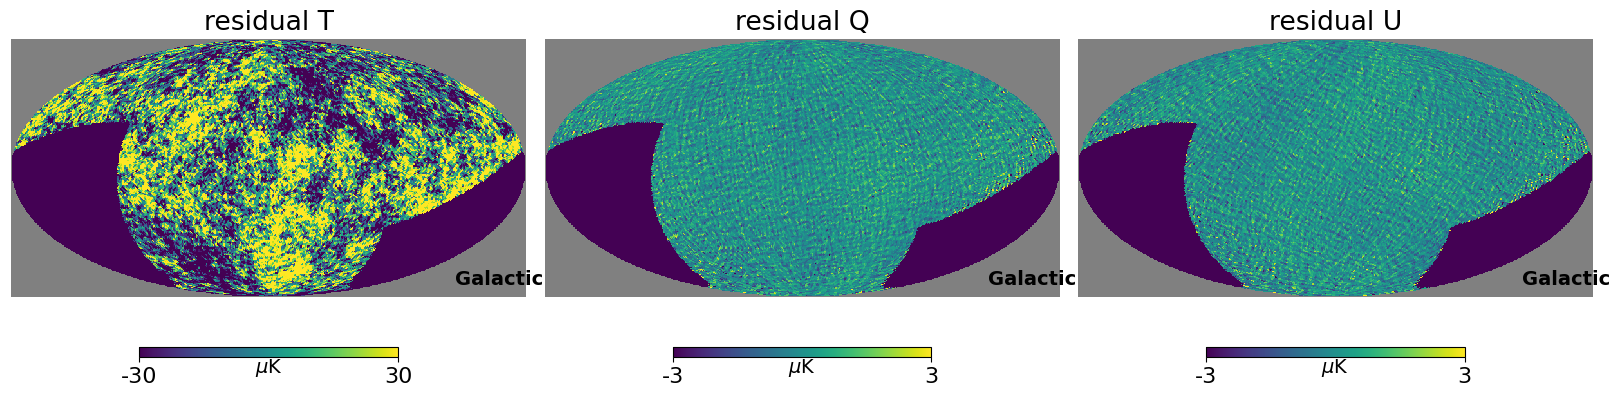

In [24]:
plt.figure(figsize=(16, 10))
ranges = 30
hp.mollview(
    (m_lbs.binned_map[0] - input_map[0]) * 1e6,
    unit="$\mu$K",
    sub=(1, 3, 1),
    title="residual T",
    coord=["G"],
    min=-ranges,
    max=ranges,
)
hp.mollview(
    (m_lbs.binned_map[1] - input_map[1]) * 1e6,
    unit="$\mu$K",
    sub=(1, 3, 2),
    title="residual Q",
    coord=["G"],
    min=-ranges * 1e-1,
    max=ranges * 1e-1,
)
hp.mollview(
    (m_lbs.binned_map[2] - input_map[2]) * 1e6,
    unit="$\mu$K",
    sub=(1, 3, 3),
    title="residual U",
    coord=["G"],
    min=-ranges * 1e-1,
    max=ranges * 1e-1,
)
plt.tight_layout()

#### Multi-frequency: building a map "on the fly", i.e. HwpSys map-maker

In [25]:
m_onthefly = hwp_sys.make_map([obs])

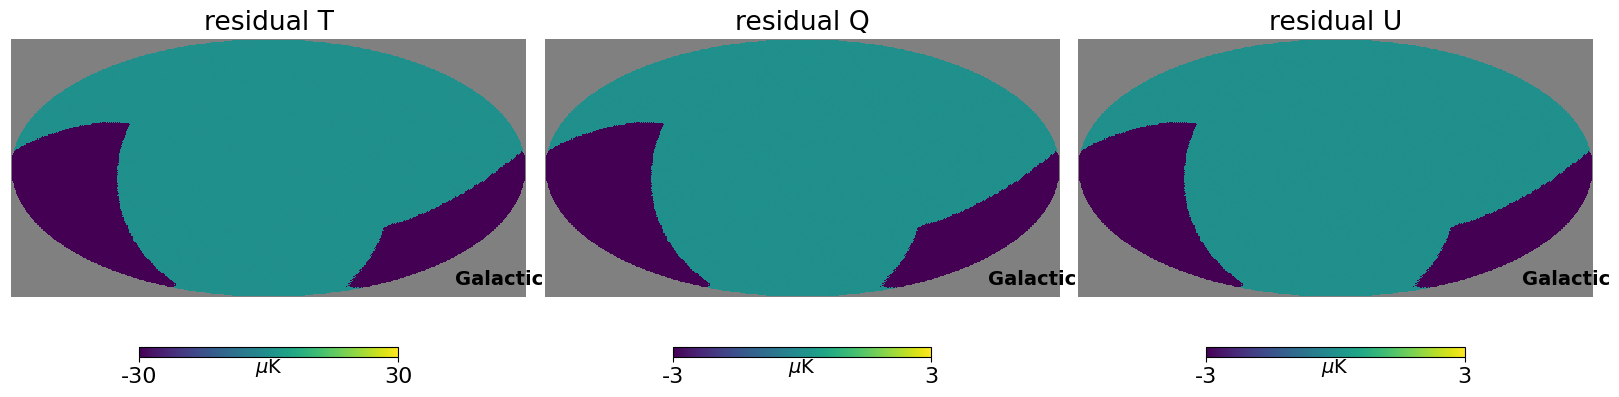

In [26]:
plt.figure(figsize=(16, 10))
ranges = 30
hp.mollview(
    (m_onthefly[0] - input_map[0]) * 1e6,
    unit="$\mu$K",
    sub=(1, 3, 1),
    title="residual T",
    coord=["G"],
    min=-ranges,
    max=ranges,
)
hp.mollview(
    (m_onthefly[1] - input_map[1]) * 1e6,
    unit="$\mu$K",
    sub=(1, 3, 2),
    title="residual Q",
    coord=["G"],
    min=-ranges * 1e-1,
    max=ranges * 1e-1,
)
hp.mollview(
    (m_onthefly[2] - input_map[2]) * 1e6,
    unit="$\mu$K",
    sub=(1, 3, 3),
    title="residual U",
    coord=["G"],
    min=-ranges * 1e-1,
    max=ranges * 1e-1,
)
plt.tight_layout()

## How to define more complex bandpass profiles

In [27]:
# general
nside = 64
sim_days = 1
channel = "M1-100"
instrument = channel[0] + "FT"
sampling = 1  # this replaces channelinfo.sampling_rate_hz
imo_version = "vPTEP"  # "v1.3"

# simulation parameters
base_path = "./HWP_tutorial"
start_time = "2030-04-01T00:00:00"

# hwp_sys parameters
integrate_in_band = "true"
integrate_in_band_solver = "true"
built_map_on_the_fly = "true"
correct_in_solver = "true"
del hwp_sys

# for band-integration, HWP systematics are passed through txt files
# order of the fields: frequency[GHz] h1 h2 beta[deg] z1 z2
# remember to set integrate_in_band and integrate_in_band_solver to 'true'
band_filename = "./MFT_100_h_beta_z.txt"  # tod filling
band_filename_solver = "./MFT_100_h_beta_z.txt"  # map-making

# bandpass params
band_low_edge = 95
band_high_edge = 103
bandcenter_ghz = 100

#### let's start with a top-hat

In [28]:
# creation of a parameter (.toml) file
toml_filename = "./HWP_tutorial.toml"
with open(toml_filename, "w") as f:
    f.write("[general]\n")  # --------------- GENERAL ---------------
    f.write("imo_version       = '" + imo_version + "'\n")
    f.write("instrument        = '" + instrument + "'\n")
    f.write("channel           = '" + channel + "'\n")
    f.write("nside             = " + str(nside) + "\n")
    f.write("mission_time_days = '" + str(sim_days) + "'\n\n")

    f.write("[simulation]\n")  # --------------- SIMULATION ---------------
    f.write("base_path  = '" + base_path + "'\n")
    f.write("start_time = '" + start_time + "'\n")
    f.write("duration_s = '" + str(sim_days) + " days'\n")
    f.write("name       = '" + "HWP_tutorial'\n\n")

    f.write("[hwp_sys]\n")  # --------------- HWP_SYS ---------------
    f.write(f"integrate_in_band        = {integrate_in_band}\n")
    f.write(f"integrate_in_band_solver = {integrate_in_band_solver}\n")
    f.write(f"built_map_on_the_fly     = {built_map_on_the_fly}\n")
    f.write(f"correct_in_solver        = {correct_in_solver}\n")
    f.write(
        "band_filename        = '" + band_filename + "'\n"
    )  # FUNDAMENTAL FOR READING HWP SYSTEMATICS PARAMETERS
    f.write(
        "band_filename_solver = '" + band_filename_solver + "'\n"
    )  # FUNDAMENTAL FOR READING HWP SYSTEMATICS PARAMETERS
    f.write("[hwp_sys.bandpass]\n")  # bandpass dictionary
    f.write("band_type       = 'top-hat' \n")
    f.write(f"band_low_edge  =  {band_low_edge}\n")
    f.write(f"band_high_edge =  {band_high_edge}\n")
    f.write(f"bandcenter_ghz =  {bandcenter_ghz}\n")
    # you can assign in the same way also the solver bandpass, defining "hwp_sys.bandpass_solver"
    f.close()

We have not created a dictionary for the solver bandpass, it will automatically consider unitary transmission over the whole frequency range in that case. To create one, just repeat the same steps as before but using the key "bandpass_solver" instead of "bandpass"

In [29]:
sim_band_int = lbs.Simulation(
    parameter_file=toml_filename,
    random_seed=0,
)

In [30]:
hwp_sys = lbs.HwpSys(sim_band_int)

hwp_sys.set_parameters(
    nside=nside,
    mueller_or_jones="jones",
    maps=np.array([input_map, input_map, input_map]),
    Channel=channelinfo,
)

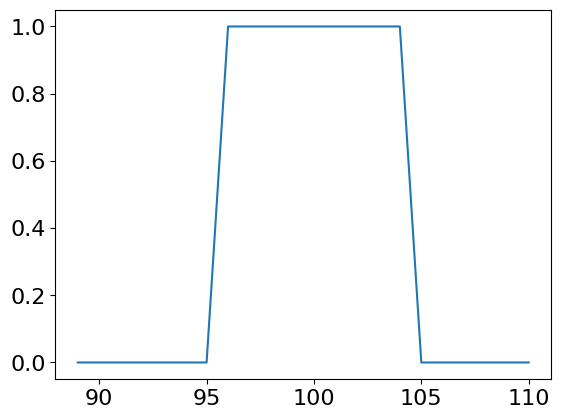

In [31]:
plt.plot(hwp_sys.freqs, hwp_sys.bandpass_profile)

#### let's now consider a Chebyshev bandpass

In [32]:
# creation of a parameter (.toml) file
toml_filename = "./HWP_tutorial.toml"
with open(toml_filename, "w") as f:
    f.write("[general]\n")  # --------------- GENERAL ---------------
    f.write("imo_version       = '" + imo_version + "'\n")
    f.write("instrument        = '" + instrument + "'\n")
    f.write("channel           = '" + channel + "'\n")
    f.write("nside             = " + str(nside) + "\n")
    f.write("mission_time_days = '" + str(sim_days) + "'\n\n")

    f.write("[simulation]\n")  # --------------- SIMULATION ---------------
    f.write("base_path  = '" + base_path + "'\n")
    f.write("start_time = '" + start_time + "'\n")
    f.write("duration_s = '" + str(sim_days) + " days'\n")
    f.write("name       = '" + "HWP_tutorial'\n\n")

    f.write("[hwp_sys]\n")  # --------------- HWP_SYS ---------------
    f.write(f"integrate_in_band        = {integrate_in_band}\n")
    f.write(f"integrate_in_band_solver = {integrate_in_band_solver}\n")
    f.write(f"built_map_on_the_fly     = {built_map_on_the_fly}\n")
    f.write(f"correct_in_solver        = {correct_in_solver}\n")
    f.write(
        "band_filename        = '" + band_filename + "'\n"
    )  # FUNDAMENTAL FOR READING HWP SYSTEMATICS PARAMETERS
    f.write(
        "band_filename_solver = '" + band_filename_solver + "'\n"
    )  # FUNDAMENTAL FOR READING HWP SYSTEMATICS PARAMETERS
    f.write("[hwp_sys.bandpass]\n")  # bandpass dictionary
    f.write("band_type       = 'cheby' \n")
    f.write(f"band_low_edge  =  {band_low_edge}\n")
    f.write(f"band_high_edge =  {band_high_edge}\n")
    f.write(f"bandcenter_ghz =  {bandcenter_ghz}\n")
    f.write("band_ripple_dB  = 0.2 \n")
    f.write("band_order      = 3 \n")

    f.close()

In [33]:
sim_band_int = lbs.Simulation(
    parameter_file=toml_filename,
    random_seed=0,
)

In [34]:
hwp_sys = lbs.HwpSys(sim_band_int)

hwp_sys.set_parameters(
    nside=nside,
    mueller_or_jones="jones",
    maps=np.array([input_map, input_map, input_map]),
    Channel=channelinfo,
)

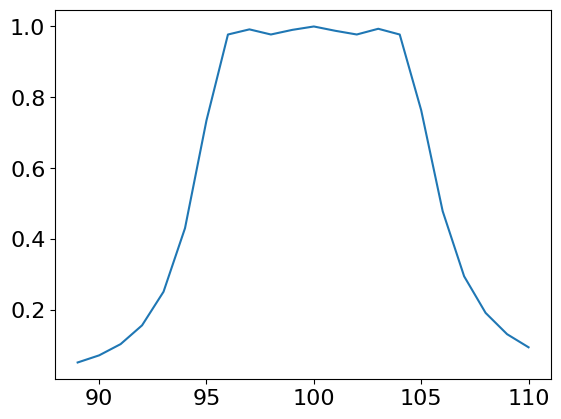

In [35]:
plt.plot(hwp_sys.freqs, hwp_sys.bandpass_profile)

#### a top-hat bandpass with exponentially decaying wings

In [36]:
# creation of a parameter (.toml) file
toml_filename = "./HWP_tutorial.toml"
with open(toml_filename, "w") as f:
    f.write("[general]\n")  # --------------- GENERAL ---------------
    f.write("imo_version       = '" + imo_version + "'\n")
    f.write("instrument        = '" + instrument + "'\n")
    f.write("channel           = '" + channel + "'\n")
    f.write("nside             = " + str(nside) + "\n")
    f.write("mission_time_days = '" + str(sim_days) + "'\n\n")

    f.write("[simulation]\n")  # --------------- SIMULATION ---------------
    f.write("base_path  = '" + base_path + "'\n")
    f.write("start_time = '" + start_time + "'\n")
    f.write("duration_s = '" + str(sim_days) + " days'\n")
    f.write("name       = '" + "HWP_tutorial'\n\n")

    f.write("[hwp_sys]\n")  # --------------- HWP_SYS ---------------
    f.write(f"integrate_in_band        = {integrate_in_band}\n")
    f.write(f"integrate_in_band_solver = {integrate_in_band_solver}\n")
    f.write(f"built_map_on_the_fly     = {built_map_on_the_fly}\n")
    f.write(f"correct_in_solver        = {correct_in_solver}\n")
    f.write(
        "band_filename        = '" + band_filename + "'\n"
    )  # FUNDAMENTAL FOR READING HWP SYSTEMATICS PARAMETERS
    f.write(
        "band_filename_solver = '" + band_filename_solver + "'\n"
    )  # FUNDAMENTAL FOR READING HWP SYSTEMATICS PARAMETERS
    f.write("[hwp_sys.bandpass]\n")  # bandpass dictionary
    f.write("band_type       = 'top-hat-exp' \n")
    f.write(f"band_low_edge  =  {band_low_edge}\n")
    f.write(f"band_high_edge =  {band_high_edge}\n")
    f.write(f"bandcenter_ghz =  {bandcenter_ghz}\n")
    f.write("alpha_exp       = 0.9 \n")
    f.write("beta_exp        = 0.9 \n")

    f.close()

In [37]:
sim_band_int = lbs.Simulation(
    parameter_file=toml_filename,
    random_seed=0,
)

In [38]:
hwp_sys = lbs.HwpSys(sim_band_int)

hwp_sys.set_parameters(
    nside=nside,
    mueller_or_jones="jones",
    maps=np.array([input_map, input_map, input_map]),
    Channel=channelinfo,
)

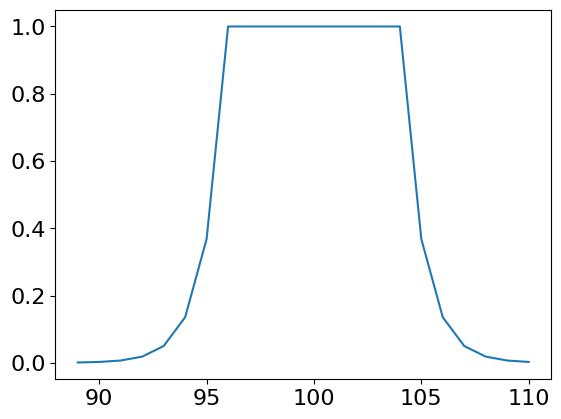

In [39]:
plt.plot(hwp_sys.freqs, hwp_sys.bandpass_profile)

#### and finally a top-hat bandpass with cosine apodization

In [40]:
# creation of a parameter (.toml) file
toml_filename = "./HWP_tutorial.toml"
with open(toml_filename, "w") as f:
    f.write("[general]\n")  # --------------- GENERAL ---------------
    f.write("imo_version       = '" + imo_version + "'\n")
    f.write("instrument        = '" + instrument + "'\n")
    f.write("channel           = '" + channel + "'\n")
    f.write("nside             = " + str(nside) + "\n")
    f.write("mission_time_days = '" + str(sim_days) + "'\n\n")

    f.write("[simulation]\n")  # --------------- SIMULATION ---------------
    f.write("base_path  = '" + base_path + "'\n")
    f.write("start_time = '" + start_time + "'\n")
    f.write("duration_s = '" + str(sim_days) + " days'\n")
    f.write("name       = '" + "HWP_tutorial'\n\n")

    f.write("[hwp_sys]\n")  # --------------- HWP_SYS ---------------
    f.write(f"integrate_in_band        = {integrate_in_band}\n")
    f.write(f"integrate_in_band_solver = {integrate_in_band_solver}\n")
    f.write(f"built_map_on_the_fly     = {built_map_on_the_fly}\n")
    f.write(f"correct_in_solver        = {correct_in_solver}\n")
    f.write(
        "band_filename        = '" + band_filename + "'\n"
    )  # FUNDAMENTAL FOR READING HWP SYSTEMATICS PARAMETERS
    f.write(
        "band_filename_solver = '" + band_filename_solver + "'\n"
    )  # FUNDAMENTAL FOR READING HWP SYSTEMATICS PARAMETERS
    f.write("[hwp_sys.bandpass]\n")  # bandpass dictionary
    f.write("band_type       = 'top-hat-cosine' \n")
    f.write(f"band_low_edge  =  {band_low_edge}\n")
    f.write(f"band_high_edge =  {band_high_edge}\n")
    f.write(f"bandcenter_ghz =  {bandcenter_ghz}\n")
    f.write("cosine_apo_length       = 2 \n")

    f.close()

In [41]:
sim_band_int = lbs.Simulation(
    parameter_file=toml_filename,
    random_seed=0,
)

In [42]:
hwp_sys = lbs.HwpSys(sim_band_int)

hwp_sys.set_parameters(
    nside=nside,
    mueller_or_jones="jones",
    maps=np.array([input_map, input_map, input_map]),
    Channel=channelinfo,
)

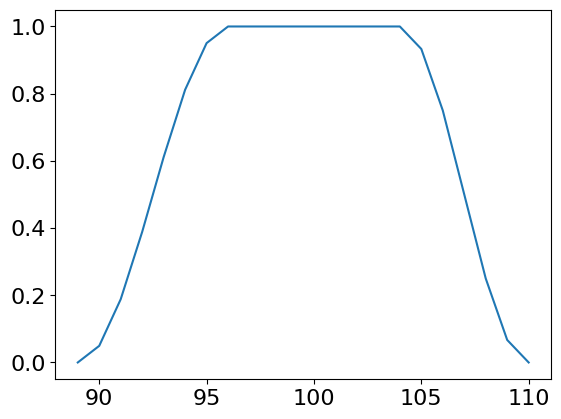

In [43]:
plt.plot(hwp_sys.freqs, hwp_sys.bandpass_profile)

### There is also the possilibity to read a bandpass profile from file. Let's first save the last bandpass profile to a  .txt file

In [44]:
np.savetxt(
    "./example_bandpass.txt", np.column_stack((hwp_sys.freqs, hwp_sys.bandpass_profile))
)

In [45]:
# creation of a parameter (.toml) file
toml_filename = "./HWP_tutorial.toml"
with open(toml_filename, "w") as f:
    f.write("[general]\n")  # --------------- GENERAL ---------------
    f.write("imo_version       = '" + imo_version + "'\n")
    f.write("instrument        = '" + instrument + "'\n")
    f.write("channel           = '" + channel + "'\n")
    f.write("nside             = " + str(nside) + "\n")
    f.write("mission_time_days = '" + str(sim_days) + "'\n\n")

    f.write("[simulation]\n")  # --------------- SIMULATION ---------------
    f.write("base_path  = '" + base_path + "'\n")
    f.write("start_time = '" + start_time + "'\n")
    f.write("duration_s = '" + str(sim_days) + " days'\n")
    f.write("name       = '" + "HWP_tutorial'\n\n")

    f.write("[hwp_sys]\n")  # --------------- HWP_SYS ---------------
    f.write(f"integrate_in_band        = {integrate_in_band}\n")
    f.write(f"integrate_in_band_solver = {integrate_in_band_solver}\n")
    f.write(f"built_map_on_the_fly     = {built_map_on_the_fly}\n")
    f.write(f"correct_in_solver        = {correct_in_solver}\n")
    f.write(
        "band_filename        = '" + band_filename + "'\n"
    )  # FUNDAMENTAL FOR READING HWP SYSTEMATICS PARAMETERS
    f.write(
        "band_filename_solver = '" + band_filename_solver + "'\n"
    )  # FUNDAMENTAL FOR READING HWP SYSTEMATICS PARAMETERS
    f.write("[hwp_sys.bandpass]\n")  # bandpass dictionary
    f.write("bandpass_file       = './example_bandpass.txt' \n")
    f.write("[hwp_sys.bandpass_solver]\n")  # bandpass solver dictionary
    f.write("bandpass_file       = './example_bandpass.txt' \n")
    f.close()

In [46]:
sim_band_int = lbs.Simulation(
    parameter_file=toml_filename,
    random_seed=0,
)

In [47]:
hwp_sys = lbs.HwpSys(sim_band_int)

hwp_sys.set_parameters(
    nside=nside,
    mueller_or_jones="jones",
    maps=np.array([input_map, input_map, input_map]),
    Channel=channelinfo,
)

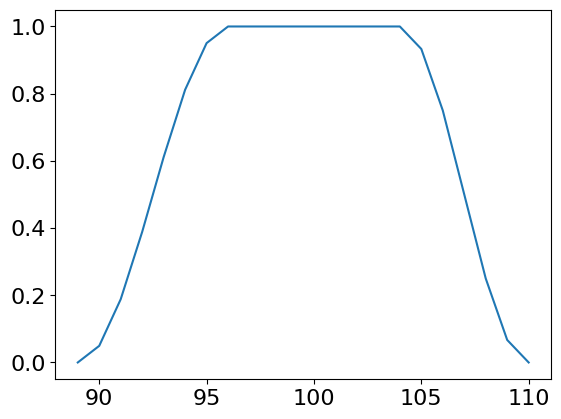

In [48]:
plt.plot(hwp_sys.freqs, hwp_sys.bandpass_profile)

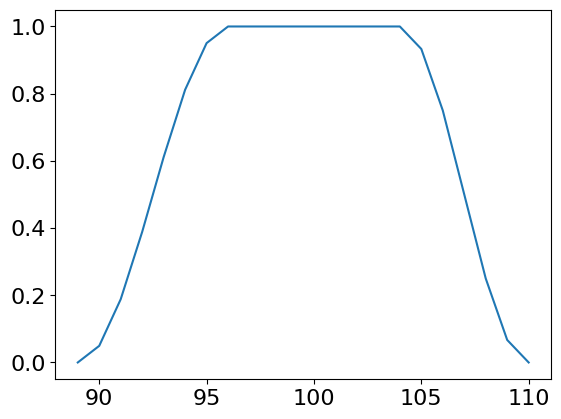

In [49]:
plt.plot(hwp_sys.freqs, hwp_sys.bandpass_profile_solver)